In [96]:
#IMPORTING LIBRARIES
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from time import perf_counter

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import  DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from keras.preprocessing import image

import tensorflow as tf

# Creating Dataframes

In [41]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [42]:
train_dir = Path('/content/drive/MyDrive/chest_xray/train')
val_dir = Path('/content/drive/MyDrive/chest_xray/val')
test_dir = Path('/content/drive/MyDrive/chest_xray/test')

In [43]:
#Creating filepaths
file_path_train = list(train_dir.glob(r'*/*.jpeg'))
file_path_val = list(val_dir.glob(r'*/*.jpeg'))
file_path_test = list(test_dir.glob(r'*/*.jpeg'))

In [44]:
#Seperating Labels
labels_train = list(map(lambda x: os.path.split(os.path.split(x)[0])[1] , file_path_train)) 
labels_val = list(map(lambda x: os.path.split(os.path.split(x)[0])[1] , file_path_val)) 
labels_test = list(map(lambda x: os.path.split(os.path.split(x)[0])[1] , file_path_test)) 

In [45]:
#Generating Columns
labels_train = pd.Series(labels_train, name='Label')
labels_val = pd.Series(labels_val, name='Label')
labels_test = pd.Series(labels_test, name='Label')

images_train = pd.Series(file_path_train, name='Path').astype(str)
images_val = pd.Series(file_path_val, name='Path').astype(str)
images_test = pd.Series(file_path_test, name='Path').astype(str)

In [46]:
# Creating Dataframe
train_df = pd.concat([images_train, labels_train],axis=1)
train_df = train_df.sample(frac=1,random_state=0).reset_index(drop = True)
val_df = pd.concat([images_val, labels_val],axis=1)
val_df = val_df.sample(frac=1,random_state=0).reset_index(drop = True)
# Combine train_df and val_df
train_df = pd.concat([train_df,val_df]).reset_index(drop = True)

test_df = pd.concat([images_test, labels_test],axis=1)
test_df = test_df.sample(frac=1,random_state=0).reset_index(drop = True)

In [47]:
print(f'Number of pictures in the training set: {train_df.shape[0]}')
print(f'Number of pictures in the test set: {test_df.shape[0]}')
print(f'Number of pictures in the validation set: {val_df.shape[0]}\n')


print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

Number of pictures in the training set: 5232
Number of pictures in the test set: 624
Number of pictures in the validation set: 16

Number of different labels: 2

Labels: ['PNEUMONIA' 'NORMAL']


,Path,Label
0,/content/drive/MyDrive/chest_xray/train/PNEUMO...,PNEUMONIA
1,/content/drive/MyDrive/chest_xray/train/PNEUMO...,PNEUMONIA
2,/content/drive/MyDrive/chest_xray/train/PNEUMO...,PNEUMONIA
3,/content/drive/MyDrive/chest_xray/train/PNEUMO...,PNEUMONIA
4,/content/drive/MyDrive/chest_xray/train/NORMAL...,NORMAL


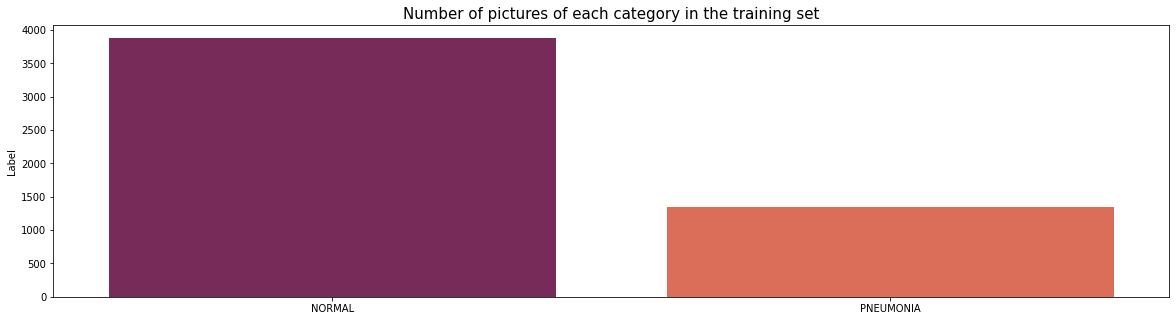

In [48]:
# Display the number of pictures of each category in the training set
import seaborn as sns

vc = train_df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Number of pictures of each category in the training set", fontsize = 15)
plt.show()

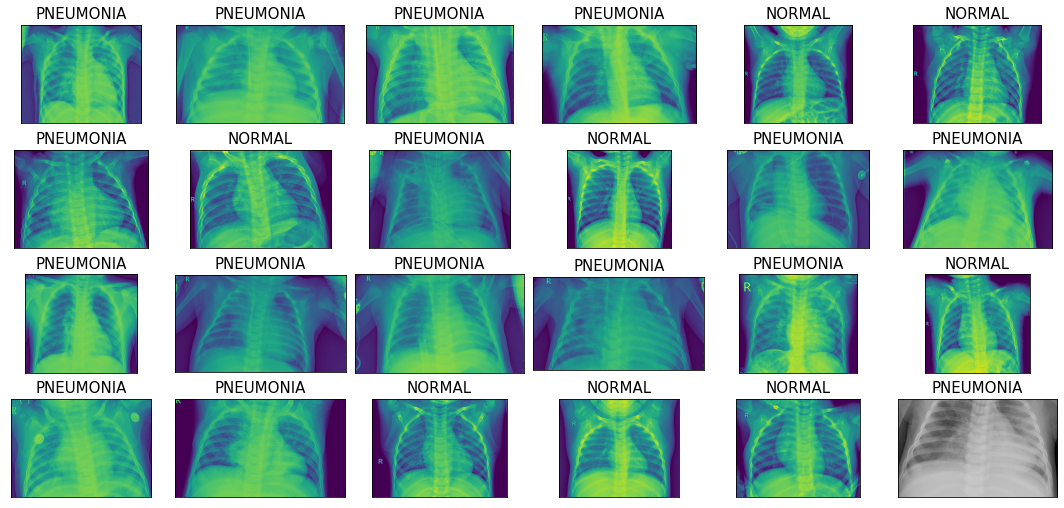

In [49]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Path[i]))
    ax.set_title(train_df.Label[i], fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

In [50]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Path',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, 
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Path',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Path',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [68]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [75]:
# Dictionary with the models
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
   
 
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
  
  
  
   
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    
    
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

Found 4709 validated image filenames belonging to 2 classes.
Found 523 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [94]:
# Fit the models
for name, model in models.items():
  m = get_model(model['model'])

  models[name]['model'] = m   
  start = perf_counter()
    
    # Fit the model
  history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # Sav the duration and the val_accuracy
  duration = perf_counter() - start
  duration = round(duration,2)
  models[name]['perf'] = duration
  print(f"{name:20} trained in {duration} sec")
    
  val_acc = history.history['val_accuracy']
  models[name]['val_acc'] = [round(v,4) for v in val_acc]

DenseNet121          trained in 66.76 sec
DenseNet201          trained in 73.44 sec
InceptionV3          trained in 63.63 sec
MobileNet            trained in 58.36 sec
VGG16                trained in 61.01 sec
Xception             trained in 63.9 sec


In [97]:
for name, model in models.items():
  # Predict the label of the test_images
  pred = models[name]['model'].predict(test_images)
  pred = np.argmax(pred,axis=1)

    # Map the label
  labels = (train_images.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  pred = [labels[k] for k in pred]

  y_test = list(test_df.Label)
  acc = accuracy_score(y_test,pred)
  models[name]['acc'] = round(acc,4)
    
    

In [98]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy (test set)','Training time (sec)'])
df_results.sort_values(by='accuracy (test set)', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_accuracy,accuracy (test set),Training time (sec)
0,MobileNet,0.9656,0.8622,58.36
1,VGG16,0.9541,0.8526,61.01
2,DenseNet201,0.9618,0.8253,73.44
3,Xception,0.9522,0.8205,63.90
4,DenseNet121,0.9579,0.7756,66.76
5,InceptionV3,0.9159,0.7660,63.63


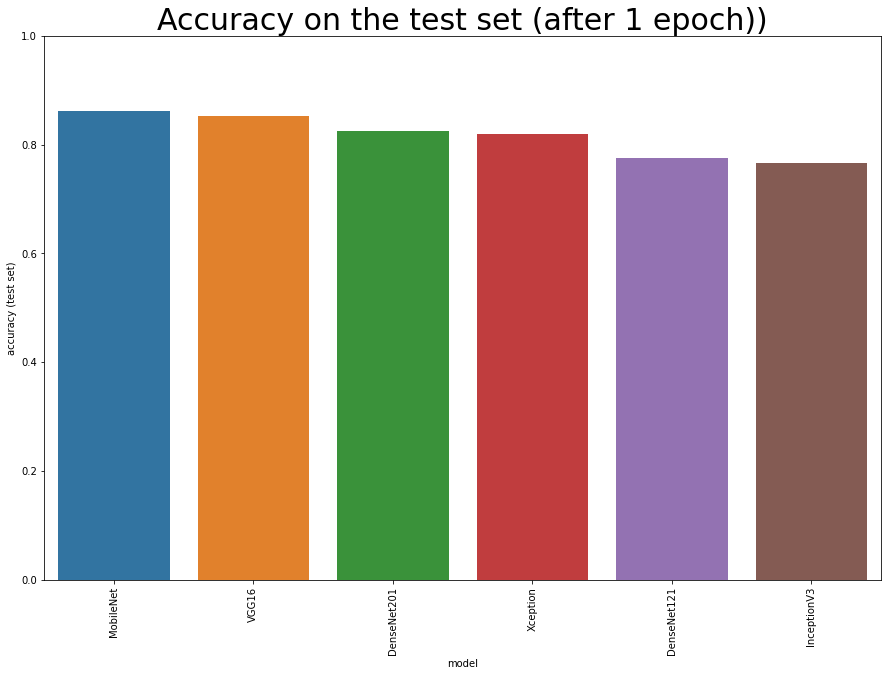

In [103]:
plt.figure(figsize = (15,10))
sns.barplot(x = 'model', y = 'accuracy (test set)', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 30)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

In [104]:
df_results

,model,val_accuracy,accuracy (test set),Training time (sec)
0,MobileNet,0.9656,0.8622,58.36
1,VGG16,0.9541,0.8526,61.01
2,DenseNet201,0.9618,0.8253,73.44
3,Xception,0.9522,0.8205,63.90
4,DenseNet121,0.9579,0.7756,66.76
5,InceptionV3,0.9159,0.7660,63.63


In [106]:
acc = df_results.iloc[0]['accuracy (test set)']
best_model = df_results.iloc[0]['model']
print(f'# Best model: {best_model}')
print(f'# Accuracy on the test set: {acc * 100:.2f}%')

# Best model: MobileNet
# Accuracy on the test set: 86.22%


Best model: DenseNet201

Accuracy on the test set: 86.22%

In [107]:
# Predict the labels of the test_images for the best model
pred = models[best_model]['model'].predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
models[name]['acc'] = round(acc,4)

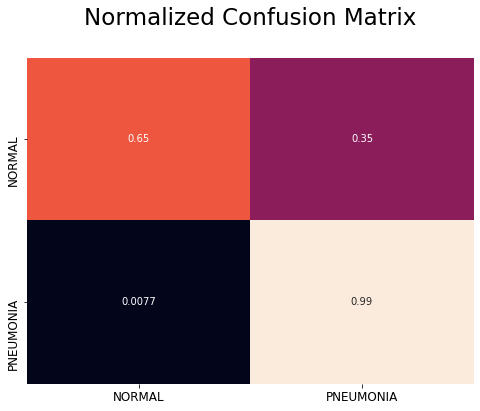

In [111]:
# Display a confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (8,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix\n', fontsize = 23)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [112]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

      NORMAL       0.98      0.65      0.78       234
   PNEUMONIA       0.82      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.82      0.84       624
weighted avg       0.88      0.86      0.85       624



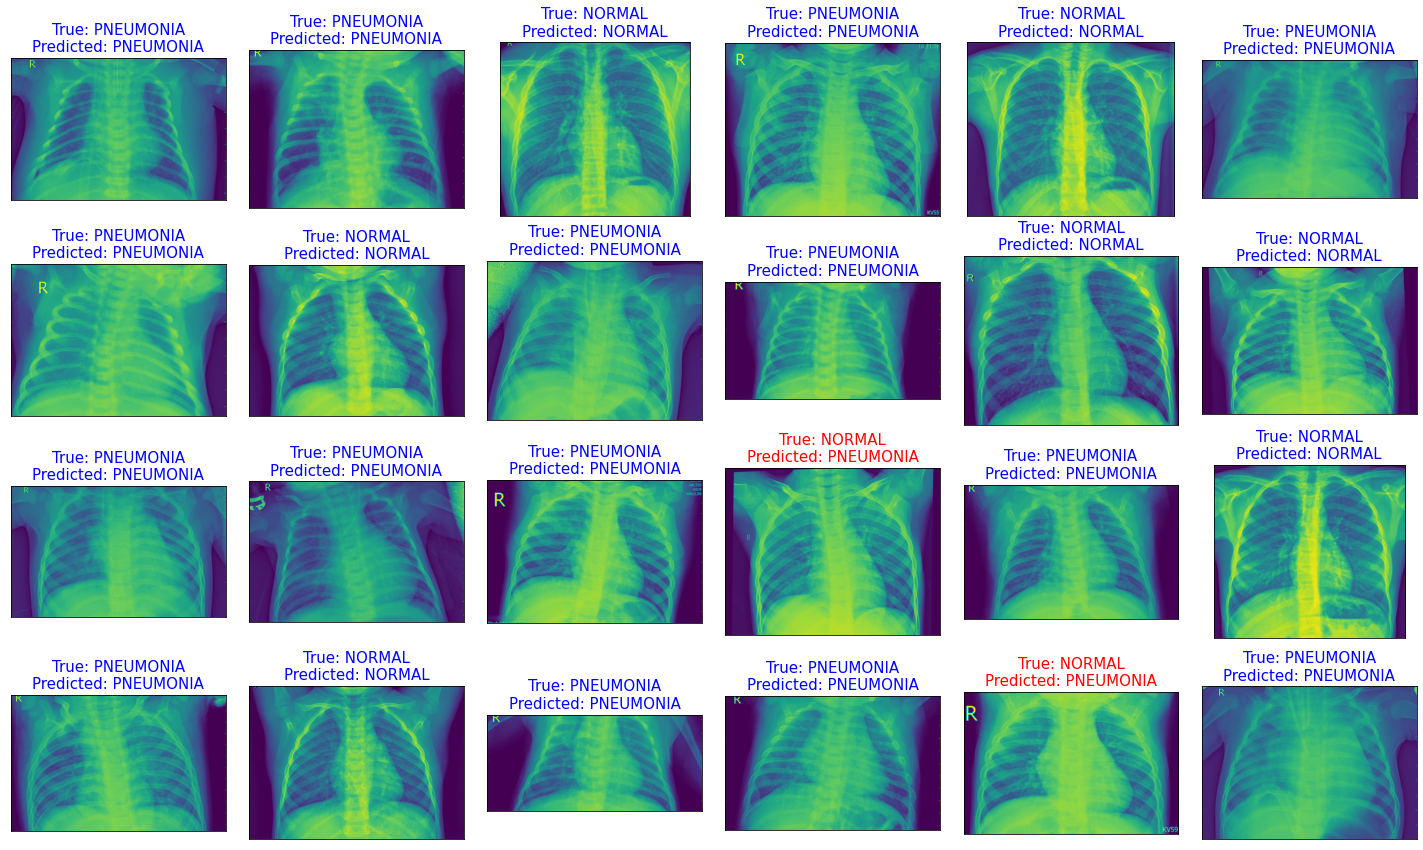

In [119]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(4,6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Path.iloc[i]))
    color = "blue" if test_df.Label.iloc[i].split('_')[0] == pred[i].split('_')[0] else "red"
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15, color = color)
plt.tight_layout()
plt.show()

In [120]:
export_path_keras = "./MobileNetXray.h5"
print(export_path_keras)

models[best_model]['model'].save(export_path_keras)

./MobileNetXray.h5


Export a whole model to the TensorFlow SavedModel format

In [125]:
export_path_sm = "./MobileNetXray_SavedModelFormat"
print(export_path_sm)
tf.saved_model.save(models[best_model]['model'], export_path_sm)

./MobileNetXray_SavedModelFormat
INFO:tensorflow:Assets written to: ./MobileNetXray_SavedModelFormat/assets


Downloading Saved Model

In [126]:
!zip -r model.zip {export_path_sm}

  adding: MobileNetXray_SavedModelFormat/ (stored 0%)
  adding: MobileNetXray_SavedModelFormat/assets/ (stored 0%)
  adding: MobileNetXray_SavedModelFormat/saved_model.pb (deflated 92%)
  adding: MobileNetXray_SavedModelFormat/variables/ (stored 0%)
  adding: MobileNetXray_SavedModelFormat/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: MobileNetXray_SavedModelFormat/variables/variables.index (deflated 76%)


In [127]:
!ls

 drive		    MobileNetXray_SavedModelFormat     sample_data
 foo.png	   'MobileNetXray(SavedModelFormat)'
 MobileNetXray.h5   model.zip
